<a href="https://colab.research.google.com/github/nhathpham/Taxi-Fleet-Management/blob/main/taxi_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Load packages and data**

In [ ]:
from google.colab import drive
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your Parquet file
file_path = '/content/drive/My Drive/USML Projects/Data/clean_data_0213.parquet'
df = pd.read_parquet(file_path)
print(len(df))

Mounted at /content/drive
1597812


In [ ]:
def plot_hist(df, col):
  plt.figure(figsize=(4, 3))

  df[col].hist(bins=100)
  plt.title(f'{col}')
  plt.show()

# **1. Clean trip data**

## **1.1 Remove trips with No Charge or Dispute payment type**

In [ ]:
print(len(df))
df = df[(df.payment_type!='No Charge')&(df.payment_type!='Dispute')] # 940
print(df.taxi_id.nunique())
print(len(df))

1597812
2864
1596872


## **1.2 Correct trip_miles, trip_seconds**

array([[<Axes: title={'center': 'trip_miles'}>,
        <Axes: title={'center': 'trip_seconds'}>],
       [<Axes: title={'center': 'trip_hours'}>,
        <Axes: title={'center': 'avg_speed_mph'}>]], dtype=object)

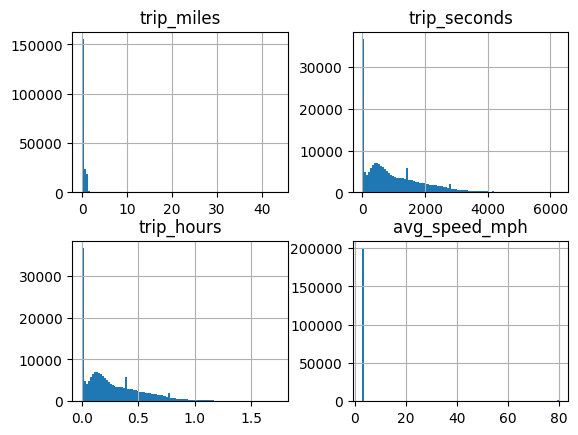

In [ ]:
# avg_speed_mph = trip_miles/trip_hours
# Step 1: Impute avg_speed_mph
df.loc[df['avg_speed_mph'] < 3, 'avg_speed_mph'] = 3
df.loc[df['avg_speed_mph'] > 80, 'avg_speed_mph'] = 80

# Step 2: Update trip_miles and trip_hours based on avg_speed_mph
df.loc[df['avg_speed_mph'] < 3, 'trip_miles'] = df['avg_speed_mph'] * df['trip_hours']
df.loc[df['avg_speed_mph'] > 80, 'trip_hours'] = df['trip_miles'] / df['avg_speed_mph']

df[df.record_error==True][['trip_miles','trip_seconds','trip_hours','avg_speed_mph']].hist(bins=100)

# **2. Create taxi-based features**

## **2.1 Total trips and total payment**

2864


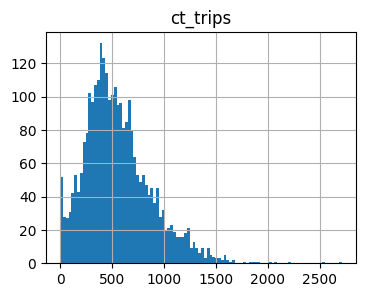

2864


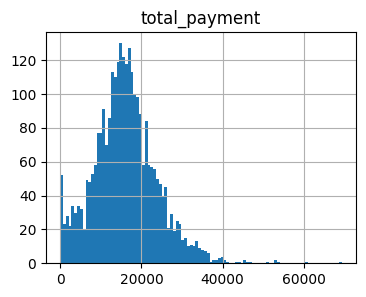

In [ ]:
# 3. Count trips
ct_trips = df.groupby('taxi_id').size().reset_index()
ct_trips.columns = ['taxi_id','ct_trips']
ct_trips.head()
print(len(ct_trips))
plot_hist(ct_trips,'ct_trips')

# 4. Count total revenue
total_payment = df.groupby('taxi_id')['trip_total'].sum().reset_index()
total_payment.columns = ['taxi_id','total_payment']
print(len(total_payment))
plot_hist(total_payment,'total_payment')

## **2.2 Median proportion of payments that are tips, for all trips with tips**
- If a trip is non credit-mobile, and has 0 tips, set the tips to NaN
- For each taxi, get median proportion of payments that are tips, for all trips with tips
- Impute taxis with missing median_pct_tips (for those without any credit-mobile payment, and without tips- missing info) with global median_pct_tips - only 24

In [ ]:
# Step 1: Initialize a DataFrame with unique taxi IDs to ensure all are included
taxi_tips = pd.DataFrame(df['taxi_id'].unique(), columns=['taxi_id'])

# Step 2: Adjust 'tips' for non-credit/mobile payments with 0 tip to NaN
df.loc[(~df['payment_type'].isin(['Credit Card', 'Mobile'])) & (df['tips'] == 0), 'tips'] = np.NaN

# Step 3: Filter and calculate median_pct_tips for all trips that have tips
# Include trips with tips regardless of payment method now, after adjustment
credit_mobile_df = df[df['payment_type'].isin(['Credit Card', 'Mobile']) | df['tips'].notna()]

pct_payments_as_tips = credit_mobile_df.groupby('taxi_id').apply(
    lambda x: (x['tips'].dropna() / x['trip_total']).median()  # Ensure to drop NaN tips before calculation
).reset_index(name='median_pct_tips')

# Step 4: Merge the pct_payments_as_tips with all_taxis to include all taxi IDs
taxi_tips = pd.merge(taxi_tips, pct_payments_as_tips, on='taxi_id', how='left')

# Step 5: Get info on whether the taxi has credit_mobile payment and whether they has tips
df['has_tip'] = df['tips'] > 0
df['is_credit_mobile'] = df['payment_type'].isin(['Credit Card', 'Mobile'])
taxi_payment_tips_info = df.groupby('taxi_id').agg({
    'is_credit_mobile': 'any',
    'has_tip': 'any'
}).reset_index()

# Merge the median tip percentages with aggregated payment and tip info
taxi_tips = pd.merge(taxi_tips, taxi_payment_tips_info, on='taxi_id', how='left')

# Step 6: fill NA in median_pct_tips (those without credit_mobile payments and without tips - missing info)
global_median_pct_tips = taxi_tips['median_pct_tips'].median()
taxi_tips['median_pct_tips'].fillna(global_median_pct_tips, inplace=True)

2864


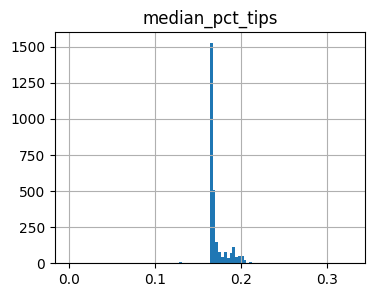

24

In [ ]:
print(len(taxi_tips))
taxi_tips_final = taxi_tips[['taxi_id','median_pct_tips']]
plot_hist(taxi_tips_final, 'median_pct_tips')
len(taxi_tips[(taxi_tips.is_credit_mobile==False) & (taxi_tips.has_tip==False)])

## **2.3 Proportion of trips with potential recording (meter) errors**
If record_error_rate affects clustering - remove records with 90%+ errored trips before clustering



2864


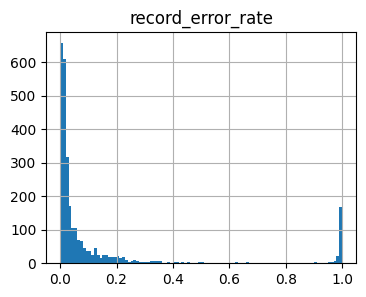

In [ ]:
# 2. Proportion of trips with potential record errors
error_rate = df.groupby('taxi_id')['record_error'].mean().reset_index(name='record_error_rate')
print(len(error_rate))
plot_hist(error_rate,'record_error_rate')

## **2.4 Median total payment per trip**

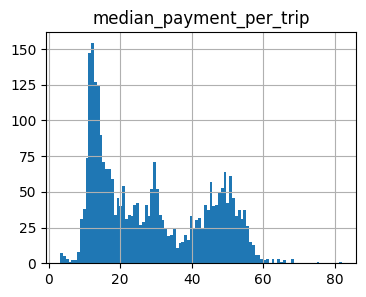

In [ ]:
payment_per_trip = df.groupby('taxi_id')['trip_total'].median().reset_index()
payment_per_trip.columns = ['taxi_id', 'median_payment_per_trip']
plot_hist(payment_per_trip,'median_payment_per_trip')

## **2.5. Median miles per trip**

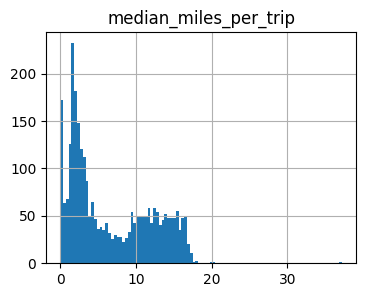

2864


In [ ]:
miles_per_trip = df.groupby('taxi_id')['trip_miles'].median().reset_index()
miles_per_trip.columns = ['taxi_id', 'median_miles_per_trip']
plot_hist(miles_per_trip,'median_miles_per_trip')
print(len(miles_per_trip))

## **2.6. Median trips per day**

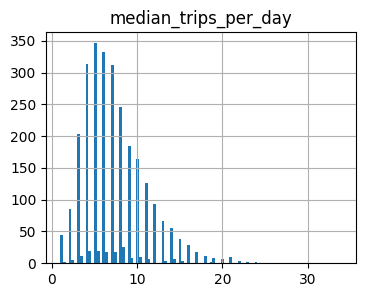

2864


In [ ]:
df['day_id'] = df['trip_start_timestamp'].dt.date

# Group by taxi_id and date to find the number of trips per day for each taxi
trips_per_day = df.groupby(['taxi_id', 'day_id']).size()
# Calculate the median number of trips per day for each taxi_id
median_trips_per_day = trips_per_day.groupby('taxi_id').median().rename('median_trips_per_day').reset_index()
median_trips_per_day.columns = ['taxi_id', 'median_trips_per_day']
plot_hist(median_trips_per_day,'median_trips_per_day')
print(len(median_trips_per_day))

## **2.7 Median idle time between trips (per day)**
- Null for between 2 days
- For taxis with only 1 trip per day (all nulls for idle_time in trip-level dataframe) - impute their median (in taxi-level df) with global median)

In [ ]:
# Sort df by taxi_id and trip end timestamp to calculate the time between trips
df_sorted = df.sort_values(by=['taxi_id', 'trip_end_timestamp'])[['taxi_id','trip_start_timestamp','trip_end_timestamp']]

# Additional step to ensure that we're calculating idle time within the same day
df_sorted['trip_start_date'] = df_sorted['trip_start_timestamp'].dt.date
df_sorted['trip_end_date'] = df_sorted['trip_end_timestamp'].dt.date

  # Sort the DataFrame by taxi_id and trip end timestamp to calculate the time between trips
df_sorted = df.sort_values(by=['taxi_id', 'trip_end_timestamp'])[['taxi_id','trip_start_timestamp','trip_end_timestamp']]
  # Calculate the time difference between the current trip start and the previous trip end
df_sorted['idle_time'] = df_sorted.groupby('taxi_id')['trip_start_timestamp'].shift(-1) - df_sorted['trip_end_timestamp']
df_sorted['idle_time_seconds'] = df_sorted['idle_time'].dt.total_seconds()
  # Set null to idle_time < 0 or between two trips in two different days
df_sorted.loc[(df_sorted['idle_time_seconds'] < 0) | (df_sorted['trip_end_timestamp'].dt.date != df_sorted['trip_start_timestamp'].shift(-1).dt.date), 'idle_time'] = pd.NA

# Convert the time difference to seconds for easier comparison and aggregation
df_sorted['idle_time_seconds'] = df_sorted['idle_time'].dt.total_seconds()

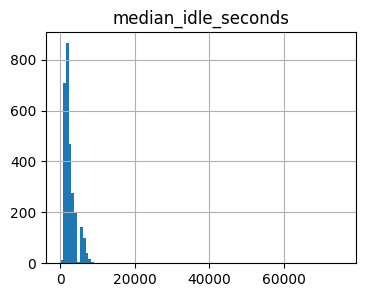

In [ ]:
idle_time = df_sorted.groupby('taxi_id')['idle_time_seconds'].median().reset_index()
idle_time.columns = ['taxi_id', 'median_idle_seconds']
plot_hist(idle_time,'median_idle_seconds')

Impute missing median_idle_seconds (between two days or timestamp error) with the median values among all taxi

In [ ]:
# Calculate the median of the non-null 'median_idle_seconds' values
median_idle_time = idle_time['median_idle_seconds'].median()

# Impute missing 'median_idle_seconds' with the calculated median
idle_time['median_idle_seconds'].fillna(median_idle_time, inplace=True)
idle_time.median_idle_seconds.describe()

count     2864.000000
mean      2617.824721
std       2460.062242
min          0.000000
25%       1350.000000
50%       1800.000000
75%       3600.000000
max      75600.000000
Name: median_idle_seconds, dtype: float64

## **2.8 Median average_speed per trip**

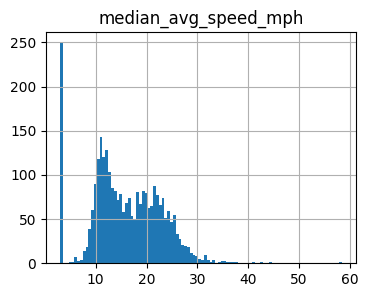

In [ ]:
avg_speed = df.groupby('taxi_id')['avg_speed_mph'].median().reset_index()
avg_speed.columns = ['taxi_id', 'median_avg_speed_mph']
plot_hist(avg_speed,'median_avg_speed_mph')

## **2.9 Utilization rate: proportion of time spent on trips vs idle**

In [ ]:
daily_trip_hours = df.groupby(['taxi_id', 'day_id'])['trip_hours'].sum().reset_index()

# Find the first trip start and last trip end for each taxi for each day
daily_operating_hours = df.groupby(['taxi_id', 'day_id']).agg(
    start_day_operating=pd.NamedAgg(column='trip_start_timestamp', aggfunc='min'),
    end_day_operating=pd.NamedAgg(column='trip_end_timestamp', aggfunc='max')
).reset_index()

# Calculate the total available hours for each taxi for each day
daily_operating_hours['available_hours'] = (daily_operating_hours['end_day_operating'] - daily_operating_hours['start_day_operating']).dt.total_seconds() / 3600

# Merge the sum of trip_hours with the available_hours to calculate the utilization rate
utilization_df = pd.merge(daily_trip_hours, daily_operating_hours, on=['taxi_id', 'day_id'])

# Calculate the utilization rate
utilization_df['utilization_rate'] = utilization_df['trip_hours'] / utilization_df['available_hours']

# Replace any infinite or NaN values with 0 (in case available_hours is 0)
utilization_df['utilization_rate'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
# utilization date per day per taxi
utilization_df.head(2)

,taxi_id,day_id,trip_hours,start_day_operating,end_day_operating,available_hours,utilization_rate
0,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,2023-09-01,2.833333,2023-09-01 09:00:00,2023-09-01 18:00:00,9.0,0.314815
1,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,2023-09-03,0.433333,2023-09-03 16:45:00,2023-09-03 18:45:00,2.0,0.216667


In [ ]:
# Set utilization_rate to 1 for all rows where utilization_rate is greater than 1
utilization_df['utilization_rate'] = np.where(utilization_df['utilization_rate'] > 1, 1, utilization_df['utilization_rate'])

# Group by taxi_id to get median trip_hours and median utilization_rate per taxi
utilization_rate = utilization_df.groupby('taxi_id').agg(
    median_trip_hours=pd.NamedAgg(column='trip_hours', aggfunc='median'),
    median_available_hours=pd.NamedAgg(column='available_hours', aggfunc='median'),
    median_daily_use_rate=pd.NamedAgg(column='utilization_rate', aggfunc='median')
).reset_index()
utilization_rate.head(2)

,taxi_id,median_trip_hours,median_available_hours,median_daily_use_rate
0,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,3.283333,9.250,0.384875
1,0044e6c0d091476299b99345501f756b23632a96cbaf40...,2.284306,10.875,0.235493


2864


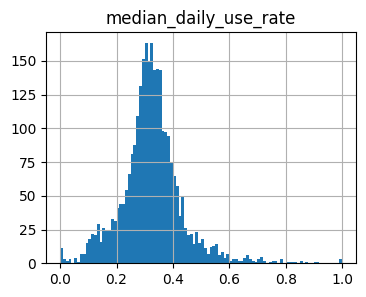

In [ ]:
print(len(utilization_rate))
utilization_rate_final = utilization_rate[['taxi_id','median_daily_use_rate']]
plot_hist(utilization_rate_final,'median_daily_use_rate')

## **2.10 Number of unique pickup community areas**

In [ ]:

# Count the number of unique community areas visited for pickup and dropoff per taxi
pickup_community_diversity = df.groupby('taxi_id')['pickup_community_area'].nunique().reset_index(name='ct_pickup_ca')
dropoff_community_diversity = df.groupby('taxi_id')['dropoff_community_area'].nunique().reset_index(name='ct_dropoff_ca')

# Count the number of unique regions visited for pickup and dropoff per taxi
#pickup_region_diversity = df.groupby('taxi_id')['pickup_region'].nunique().reset_index(name='ct_pickup_region')
#dropoff_region_diversity = df.groupby('taxi_id')['dropoff_region'].nunique().reset_index(name='ct_dropoff_region')

# Merge all the diversity metrics into one DataFrame
service_area_diversity = pickup_community_diversity.merge(
    dropoff_community_diversity, on='taxi_id')#.merge(
    #pickup_region_diversity, on='taxi_id')#.merge(
    #dropoff_region_diversity, on='taxi_id')

In [ ]:
print(len(service_area_diversity))
service_area_diversity.head(2)

2864


,taxi_id,ct_pickup_ca,ct_dropoff_ca
0,0041f8f0c91881c1e1913f2548522495fe3c4c719aa67f...,37,56
1,0044e6c0d091476299b99345501f756b23632a96cbaf40...,25,30


## **2.11 Proportion of each payment type**

In [ ]:

# Step 1: Replace all other payment types with 'Other'
# Define categories to keep
categories_to_keep = ['Credit Card', 'Cash', 'Mobile']

# Replace all other payment types with 'Other'
df['payment_type'] = df['payment_type'].apply(lambda x: x if x in categories_to_keep else 'Other')

# Step 2: Create dummy variables for each payment type
payment_dummies = pd.get_dummies(df[['taxi_id', 'payment_type']], columns=['payment_type'])

# Step 3: Group by taxi_id and calculate the proportion of each payment type
payment_type_proportions = payment_dummies.groupby('taxi_id').mean()

In [ ]:
print(len(payment_type_proportions))
payment_type_proportions.head(2)

2864


,payment_type_Cash,payment_type_Credit Card,payment_type_Mobile,payment_type_Other
taxi_id,,,,
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd2483ebbcc22e0aa1bfff2cddb32c35cde3ad9766b0e8d44c04ff5dfdcf1035462ba81a13e3ba6b8f9,0.321727,0.349582,0.000000,0.328691
0044e6c0d091476299b99345501f756b23632a96cbaf40e872fbf14f976410d3f938aacc643ed608b2aa42809222d4458e1aab5e0848e9b952f35616785c3a36,0.234293,0.575916,0.188482,0.001309


## **2.12 Proportion of trips in each time period**

In [ ]:
# Step 1: Create dummy variables for each period_start category
period_start_dummies = pd.get_dummies(df[['taxi_id', 'period_start']], columns=['period_start'])

# Step 2: Group by taxi_id and calculate the sum of each dummy variable
# This gives us the count of trips in each period_start category for each taxi
period_counts = period_start_dummies.groupby('taxi_id').sum()

# Step 3: Calculate the total number of trips for each taxi
total_trips_per_taxi = period_counts.sum(axis=1)

# Step 4: Calculate the proportion of each category
period_proportions = period_counts.div(total_trips_per_taxi, axis=0)
period_proportions.head(2)

,period_start_Afternoon,period_start_Early Morning,period_start_Evening,period_start_Evening Rush,period_start_Midday,period_start_Morning Rush,period_start_Night
taxi_id,,,,,,,
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd2483ebbcc22e0aa1bfff2cddb32c35cde3ad9766b0e8d44c04ff5dfdcf1035462ba81a13e3ba6b8f9,0.292479,0.000000,0.062674,0.303621,0.277159,0.064067,0.0
0044e6c0d091476299b99345501f756b23632a96cbaf40e872fbf14f976410d3f938aacc643ed608b2aa42809222d4458e1aab5e0848e9b952f35616785c3a36,0.226440,0.001309,0.096859,0.257853,0.234293,0.183246,0.0


## **2.13 Proportion of trips in each pickup_region**

In [ ]:

# Step 1: Create dummy variables for each period_start category
pickup_region_dummies = pd.get_dummies(df[['taxi_id', 'pickup_region']], columns=['pickup_region'])

# Step 2: Group by taxi_id and calculate the sum of each dummy variable
# This gives us the count of trips in each period_start category for each taxi
pickup_region_counts = pickup_region_dummies.groupby('taxi_id').sum()

# Step 3: Calculate the total number of trips for each taxi
total_trips_per_taxi = pickup_region_counts.sum(axis=1)

# Step 4: Calculate the proportion of each category
pickup_region_proportions = pickup_region_counts.div(total_trips_per_taxi, axis=0)
#period_proportions.head()
pickup_region_proportions.head(2)

,"pickup_region_Central, Near North, & Near South",pickup_region_Far North,pickup_region_Far South,pickup_region_Far Southwest,pickup_region_North,pickup_region_Northwest,pickup_region_South,pickup_region_Southwest,pickup_region_West & Near West
taxi_id,,,,,,,,,
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd2483ebbcc22e0aa1bfff2cddb32c35cde3ad9766b0e8d44c04ff5dfdcf1035462ba81a13e3ba6b8f9,0.341226,0.100279,0.019499,0.002786,0.006964,0.008357,0.371866,0.013928,0.135097
0044e6c0d091476299b99345501f756b23632a96cbaf40e872fbf14f976410d3f938aacc643ed608b2aa42809222d4458e1aab5e0848e9b952f35616785c3a36,0.454188,0.331152,0.000000,0.001309,0.044503,0.000000,0.034031,0.089005,0.045812


## **2.14 Number of trips in weekend/ Number of trips in weekday**

In [ ]:
# Group by taxi_id and is_weekend, and count the number of trips
weekend_weekday_counts = df.groupby(['taxi_id', 'is_weekend']).size().unstack(fill_value=0)

# Adjust the calculation of the ratio of weekend trips to weekday trips for each taxi
# Here, 0 represents weekdays and 1 represents weekends
weekend_weekday_counts['weekend_to_weekday_ratio'] = weekend_weekday_counts[1] / (weekend_weekday_counts[0] + 1e-9)

# Reset index to make taxi_id a column again
weekend_weekday_counts.reset_index(inplace=True)

2864


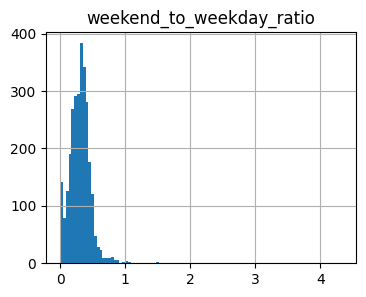

In [ ]:
print(len(weekend_weekday_counts))
weekend_weekday_counts_final = weekend_weekday_counts[['taxi_id','weekend_to_weekday_ratio']]
plot_hist(weekend_weekday_counts_final, 'weekend_to_weekday_ratio')

## **2.15 Surcharged proportion**

In [ ]:
df['is_surcharged'] = (df['extras'] > 0)

# Step 2: Group by taxi_id and calculate the total number of trips and the number of surcharged trips
surcharge_stats = df.groupby('taxi_id')['is_surcharged'].agg(['sum', 'size']).reset_index()

# Rename columns for clarity
surcharge_stats.columns = ['taxi_id', 'surcharged_trips', 'total_trips']

# Step 3: Calculate the proportion of surcharged trips for each taxi
surcharge_stats['surcharge_proportion'] = surcharge_stats['surcharged_trips'] / surcharge_stats['total_trips']

2864


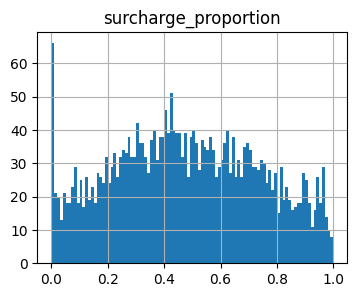

In [ ]:
print(len(surcharge_stats))
plot_hist(surcharge_stats,'surcharge_proportion')
surcharge_stats_final = surcharge_stats[['taxi_id','surcharge_proportion']]

## **2.16. Company name**

In [ ]:
# Get the mode 'company' for each taxi_id
company = df.groupby('taxi_id')['company'].agg(lambda x: x.mode().iat[0]).reset_index(name='company')
company.company.nunique()

31

## **2.17. Median payment per day**

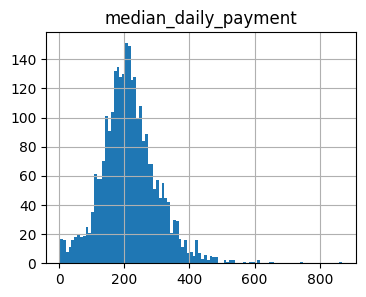

In [ ]:
# Sum payments per taxi per day
daily_payments = df.groupby(['taxi_id', 'day_id'])['trip_total'].sum().reset_index()

# Calculate median daily payment per taxi
median_daily_payment = daily_payments.groupby('taxi_id')['trip_total'].median().reset_index(name='median_daily_payment')
plot_hist(median_daily_payment,'median_daily_payment')


## **2.18 Median miles per day**

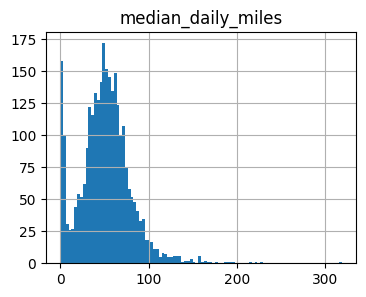

In [ ]:
# Sum payments per taxi per day
daily_miles = df.groupby(['taxi_id', 'day_id'])['trip_miles'].sum().reset_index()

# Calculate median daily payment per taxi
median_daily_miles = daily_miles.groupby('taxi_id')['trip_miles'].median().reset_index(name='median_daily_miles')
plot_hist(median_daily_miles,'median_daily_miles')


## **2.19. Proportion of pick up community areas**

In [ ]:
# Step 1: Create dummy variables for each period_start category
pickup_ca_dummies = pd.get_dummies(df[['taxi_id', 'pickup_ca_name']], columns=['pickup_ca_name'])

# Step 2: Group by taxi_id and calculate the sum of each dummy variable
# This gives us the count of trips in each period_start category for each taxi
pickup_ca_counts = pickup_ca_dummies.groupby('taxi_id').sum()

# Step 3: Calculate the total number of trips for each taxi
total_trips_per_taxi = pickup_ca_counts.sum(axis=1)

# Step 4: Calculate the proportion of each category
pickup_ca_proportions = pickup_ca_counts.div(total_trips_per_taxi, axis=0)
pickup_ca_proportions.head(2)

,pickup_ca_name_Albany Park,pickup_ca_name_Archer Heights,pickup_ca_name_Armour Square,pickup_ca_name_Ashburn,pickup_ca_name_Auburn Gresham,pickup_ca_name_Austin,pickup_ca_name_Avalon Park,pickup_ca_name_Avondale,pickup_ca_name_Belmont Cragin,pickup_ca_name_Beverly,pickup_ca_name_Bridgeport,pickup_ca_name_Brighton Park,pickup_ca_name_Burnside,pickup_ca_name_Calumet Heights,pickup_ca_name_Chatham,pickup_ca_name_Chicago Lawn,pickup_ca_name_Clearing,pickup_ca_name_Douglas,pickup_ca_name_Dunning,pickup_ca_name_East Garfield Park,pickup_ca_name_East Side,pickup_ca_name_Edgewater,pickup_ca_name_Edison Park,pickup_ca_name_Englewood,pickup_ca_name_Forest Glen,pickup_ca_name_Fuller Park,pickup_ca_name_Gage Park,pickup_ca_name_Garfield Ridge,pickup_ca_name_Grand Boulevard,pickup_ca_name_Greater Grand Crossing,pickup_ca_name_Hegewisch,pickup_ca_name_Hermosa,pickup_ca_name_Humboldt Park,pickup_ca_name_Hyde Park,pickup_ca_name_Irving Park,pickup_ca_name_Jefferson Park,pickup_ca_name_Kenwood,pickup_ca_name_Lake View,pickup_ca_name_Lincoln Park,pickup_ca_name_Lincoln Square,pickup_ca_name_Logan Square,pickup_ca_name_Loop,pickup_ca_name_Lower West Side,pickup_ca_name_Mckinley Park,pickup_ca_name_Montclare,pickup_ca_name_Morgan Park,pickup_ca_name_Mount Greenwood,pickup_ca_name_Near North Side,pickup_ca_name_Near South Side,pickup_ca_name_Near West Side,pickup_ca_name_New City,pickup_ca_name_North Center,pickup_ca_name_North Lawndale,pickup_ca_name_North Park,pickup_ca_name_Norwood Park,pickup_ca_name_Oakland,pickup_ca_name_Ohare,pickup_ca_name_Portage Park,pickup_ca_name_Pullman,pickup_ca_name_Riverdale,pickup_ca_name_Rogers Park,pickup_ca_name_Roseland,pickup_ca_name_South Chicago,pickup_ca_name_South Deering,pickup_ca_name_South Lawndale,pickup_ca_name_South Shore,pickup_ca_name_Uptown,pickup_ca_name_Washington Heights,pickup_ca_name_Washington Park,pickup_ca_name_West Elsdon,pickup_ca_name_West Englewood,pickup_ca_name_West Garfield Park,pickup_ca_name_West Lawn,pickup_ca_name_West Pullman,pickup_ca_name_West Ridge,pickup_ca_name_West Town,pickup_ca_name_Woodlawn
taxi_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0041f8f0c91881c1e1913f2548522495fe3c4c719aa67fd2483ebbcc22e0aa1bfff2cddb32c35cde3ad9766b0e8d44c04ff5dfdcf1035462ba81a13e3ba6b8f9,0.002786,0.0,0.005571,0.000000,0.0,0.0,0.002786,0.0,0.0,0.0,0.000000,0.0,0.0,0.001393,0.005571,0.0,0.0,0.023677,0.0,0.0,0.0,0.000000,0.0,0.001393,0.0,0.0,0.0,0.011142,0.016713,0.001393,0.0,0.0,0.0,0.189415,0.006964,0.001393,0.079387,0.002786,0.001393,0.0,0.002786,0.140669,0.001393,0.0,0.0,0.001393,0.0,0.123955,0.076602,0.110028,0.001393,0.000000,0.015320,0.0,0.0,0.012535,0.096100,0.001393,0.001393,0.0,0.0,0.0,0.006964,0.001393,0.0,0.020891,0.000000,0.001393,0.004178,0.0,0.0,0.002786,0.000000,0.0,0.0,0.005571,0.018106
0044e6c0d091476299b99345501f756b23632a96cbaf40e872fbf14f976410d3f938aacc643ed608b2aa42809222d4458e1aab5e0848e9b952f35616785c3a36,0.000000,0.0,0.001309,0.001309,0.0,0.0,0.000000,0.0,0.0,0.0,0.001309,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001309,0.0,0.0,0.0,0.003927,0.0,0.000000,0.0,0.0,0.0,0.087696,0.002618,0.000000,0.0,0.0,0.0,0.018325,0.000000,0.001309,0.005236,0.014398,0.022251,0.0,0.002618,0.170157,0.000000,0.0,0.0,0.000000,0.0,0.225131,0.058901,0.040576,0.000000,0.005236,0.001309,0.0,0.0,0.002618,0.324607,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.001309,0.000000,0.001309,0.0,0.0,0.000000,0.001309,0.0,0.0,0.003927,0.000000


In [ ]:
pickup_ca_proportions.shape

(2864, 77)

# **3. Put all features into taxi dataframe**

In [ ]:
from functools import reduce

dataframes = [ct_trips, total_payment,taxi_tips_final, error_rate,
              payment_per_trip, miles_per_trip, median_trips_per_day, idle_time,
              avg_speed, utilization_rate_final, service_area_diversity,
              payment_type_proportions, period_proportions,
              pickup_region_proportions, weekend_weekday_counts_final,
              surcharge_stats_final, company,median_daily_payment,
              median_daily_miles, pickup_ca_proportions]
# Use functools.reduce to iteratively merge all DataFrames on 'taxi_id'
taxi_df = reduce(lambda left, right: pd.merge(left, right, on='taxi_id', how='left'), dataframes)

In [ ]:
taxi_df.columns = [col.lower().replace(" ", "_") for col in taxi_df.columns]
taxi_df = taxi_df.rename(columns={
    "pickup_region_central,_near_north,_&_near_south": "pickup_region_central",
    "pickup_region_west_&_near_west  ": "pickup_region_west_near_west"  # Trimming any trailing spaces in the original name
})

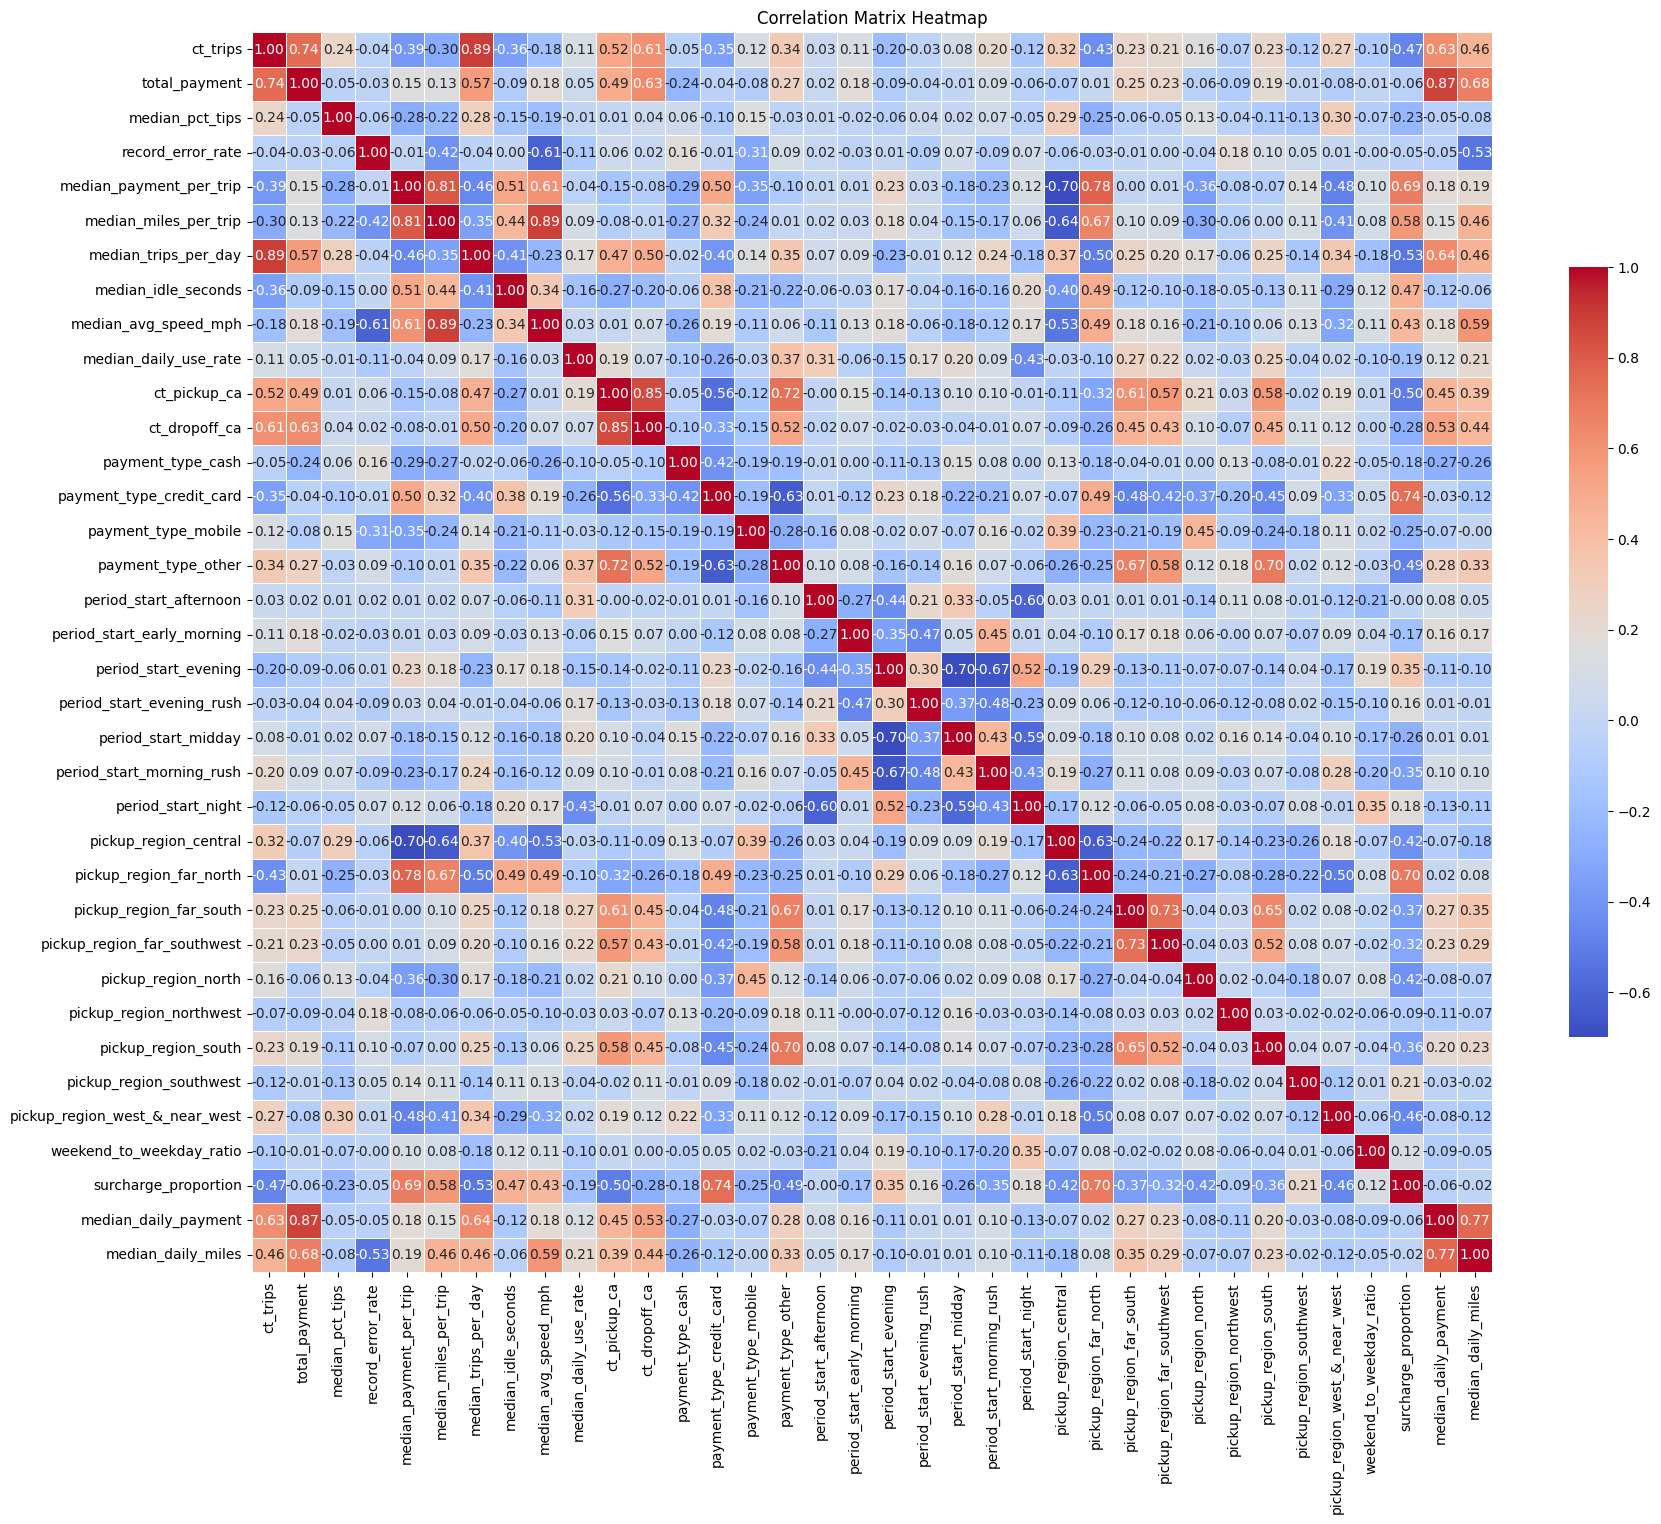

In [ ]:
# Calculate the correlation matrix
correlation_matrix = taxi_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .5}, linewidths=.5)

plt.title('Correlation Matrix Heatmap')
plt.show()

- The correlation between surcharged_proportion and payment_type_credit_card is logical due to the surcharge policy on credit card payments. However, since this correlation is informed by a real-world relationship, it might still be valuable to include it in the clustering analysis to see if it naturally forms a part of the clusters' characteristics.
- Decide to keep both: surcharged_proportion as it provides insight into how often additional charges are applied, which could influence profitability or indicate certain types of trips, payment_type_credit_card, because they offer a profile of payment preferences, which could be significant for understanding different operational segments.
-  If the clustering results appear skewed by these correlations, you could revisit this decision and consider the alternative strategies mentioned earlier.

# **4. Export data**

In [ ]:
file_path = '/content/drive/My Drive/USML Projects/Data/clean_taxi_full.parquet'
taxi_df.to_parquet(file_path, index=False)